In [19]:
from torchtext.data.utils import get_tokenizer


In [2]:
from datasets import load_dataset

# Load the dataset (raw text version)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_iter = dataset['train']['text']


In [3]:
# subset
# train_iter = dataset['train'].select(range(1000))['text']


In [4]:
type(train_iter)

list

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader, Dataset


In [6]:

# 1. Load  WikiText
tokenizer = get_tokenizer('basic_english')


In [7]:

# Build vocabulary
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = {word: i for i, (word, _) in enumerate(counter.items())}
vocab_size = len(vocab)


In [8]:
len(vocab)

66057

In [9]:
# example
first_key = next(iter(vocab))
first_value = vocab[first_key]

print(f"First key: {first_key}, First value: {first_value}")

First key: =, First value: 0


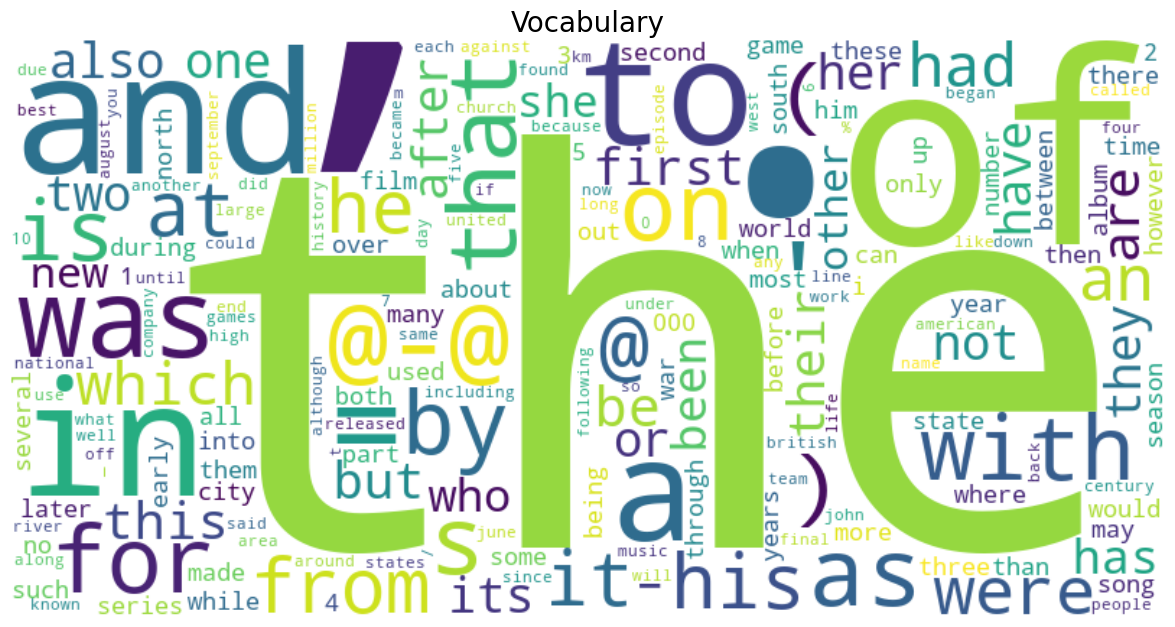

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Vocabulary", fontsize=20)
plt.show()


In [11]:

CONTEXT_SIZE = 2
data = []
for line in train_iter:
    tokens = tokenizer(line)
    if len(tokens) < 2 * CONTEXT_SIZE + 1:
        continue  # skip short lines
    for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):
        context = [tokens[j] for j in range(i - CONTEXT_SIZE, i)] + \
                  [tokens[j] for j in range(i + 1, i + CONTEXT_SIZE + 1)]
        target = tokens[i]
        data.append((context, target))


class CBOWDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idxs = torch.tensor([self.vocab[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor(self.vocab[target], dtype=torch.long)
        return context_idxs, target_idx

dataset = CBOWDataset(data, vocab)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


# 2. Define model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)
        avg_embeds = embeds.mean(dim=1)
        out = self.linear(avg_embeds)
        return out
    def get_embedding(self, words, vocab):
        idxs = torch.tensor([vocab[w] for w in words if w in vocab], dtype=torch.long)
        return self.embeddings(idxs)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim = 300
model = CBOWModel(vocab_size, embedding_dim).to(device)

In [13]:
# Load
embeddings = torch.load("embeddings-300dim-20e.pt",  map_location='cpu')

In [14]:
# 4. Get embeddings for a string
def get_string_embedding(model, input_string, vocab):
    tokens = tokenizer(input_string)
    with torch.no_grad():
        # Get the device of the model's embedding layer
        device = next(model.parameters()).device
        # Convert tokens to indices and move to the correct device
        idxs = torch.tensor([vocab[w] for w in tokens if w in vocab], dtype=torch.long, device=device)
        embedding = model.embeddings(idxs)
    return embedding


In [15]:

# Example embedding
embedding = get_string_embedding(model, "hacker news", vocab)
print(embedding)

tensor([[ 1.3020e+00, -5.3635e-01,  8.8950e-01,  9.9177e-01,  7.0927e-01,
          2.3255e+00, -1.2891e+00, -1.4229e+00,  3.0113e-01,  8.4163e-02,
          7.9924e-01, -2.4320e-01,  3.0540e-01, -1.8821e+00, -8.4829e-01,
         -2.1376e+00, -1.8180e+00, -5.1826e-01, -2.7233e-01, -4.7457e-02,
         -9.3288e-01, -9.3525e-01, -3.4247e-01, -8.3839e-01,  4.6690e-01,
          9.1307e-01,  2.3683e-01,  3.8794e-01, -4.6923e-01,  6.7847e-01,
         -1.6431e-01,  1.8789e-01, -1.6838e-01, -1.0936e-01, -1.7129e+00,
         -5.5951e-01, -4.9692e-01,  5.9091e-01,  1.0499e+00, -3.6929e-02,
         -3.9395e-01, -1.0106e+00, -3.2555e-01,  3.6127e-01,  6.3696e-01,
          1.2507e+00,  1.2613e-01,  1.1000e+00,  4.3741e-01,  2.9424e+00,
         -9.1655e-02, -2.1102e-01, -1.7931e+00, -6.7481e-01, -1.5488e-01,
         -1.7186e+00, -2.4019e+00,  1.5816e+00,  7.2852e-01, -2.7592e-02,
         -5.6549e-01, -2.4700e-01, -1.7246e-01, -6.4160e-01,  3.4002e+00,
          9.3255e-01, -1.6282e-01, -7.

---

In [16]:
word = "computer"
word_idx = vocab.get(word)
if word_idx is None:
    raise ValueError(f"'{word}' not in vocabulary.")

In [ ]:
from torch.nn.functional import cosine_similarity

computer_embedding = embeddings[word_idx].unsqueeze(0)  # Shape [1, embedding_dim]

# Compute cosine similarity for all other words
similarities = cosine_similarity(computer_embedding, embeddings)  # Shape [vocab_size]

In [18]:
# Exclude the word itself by setting its similarity to -inf
similarities[word_idx] = float('-inf')

# Get top N most similar word indices
top_n = 10
top_indices = torch.topk(similarities, top_n).indices.tolist()

# Build reverse vocab (index to word)
idx_to_word = {idx: word for word, idx in vocab.items()}

# Decode indices to words
top_words = [idx_to_word[idx] for idx in top_indices]
print(f"Top {top_n} words most similar to '{word}':")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {idx_to_word[idx]} (similarity: {similarities[idx]:.4f})")

Top 10 words most similar to 'computer':
1. jade (similarity: 0.2586)
2. boldest (similarity: 0.2528)
3. fouke (similarity: 0.2361)
4. imperative (similarity: 0.2328)
5. etiquette (similarity: 0.2229)
6. tegami (similarity: 0.2193)
7. azzam (similarity: 0.2178)
8. mesas (similarity: 0.2150)
9. whitlock (similarity: 0.2150)
10. witenagemot (similarity: 0.2147)


---
Analogy eval

In [ ]:

# Load embeddings and vocab (again - just to be sure)
embeddings = torch.load("embeddings-300dim-20e.pt", map_location='cpu')

word_to_ix = vocab
ix_to_word = {i: w for w, i in word_to_ix.items()}

def get_embedding(word):
    if word in word_to_ix:
        return embeddings[word_to_ix[word]]
    return None



# Analogy test
def analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions):
    print("\n--- Analogy Test ---")
    for a, b, c, expected_d in analogy_questions:
        emb_a = get_embedding(a)
        emb_b = get_embedding(b)
        emb_c = get_embedding(c)

        if all([emb_a is not None, emb_b is not None, emb_c is not None]):
            analogy_vector = emb_b - emb_a + emb_c

            # Normalize analogy_vector
            analogy_vector = analogy_vector / (analogy_vector.norm() + 1e-8)

            max_similarity = -1
            best_word = None

            for word, idx in word_to_ix.items():
                if word in [a, b, c]:
                    continue

                word_embedding = embeddings[idx]
                word_embedding = word_embedding / (word_embedding.norm() + 1e-8)

                similarity = torch.dot(analogy_vector, word_embedding).item()

                if similarity > max_similarity:
                    max_similarity = similarity
                    best_word = word

            print(f"'{a}' is to '{b}' as '{c}' is to '{best_word}' (Expected: '{expected_d}')")
        else:
            print(f"Skipping analogy '{a}' is to '{b}' as '{c}' is to '{expected_d}' due to missing word(s).")

# ------------------------------------------
# Sample Analogy Questions
# ------------------------------------------
analogy_questions = [
    ("king", "man", "woman", "queen"),
    ("walk", "walking", "swim", "swimming"),
    ("london", "england", "paris", "france"),
    ("great", "greater", "good", "better"),
    ("big", "biggest", "small", "smallest"),
    ("apple", "iphone", "google", "android"),
    ("microsoft", "windows", "apple", "macos"),
    ("code", "programming", "data", "analysis"),
    ("new", "update", "old", "legacy"),
    ("startup", "founder", "company", "ceo"),
    ("bitcoin", "cryptocurrency", "dollar", "fiat")
]


In [ ]:

# run the test
analogy_test_pytorch(word_to_ix, ix_to_word, embeddings, analogy_questions)
